## <center>Assignment</center>


1. Implement the [Improved WGAN](https://arxiv.org/pdf/1704.00028.pdf).
2. Train the Improved WGAN on [CelebA](https://www.kaggle.com/c/datalab-lab-14-2/data?fbclid=IwAR0z0lDESiGwLJ8o00b2V5YrKq01SpFkx6t2jbeNaWQ7g_MMIllaa1nuYU0#) dataset. Build dataset that **read** and **resize** images to **64 x 64** for training.
3. Show a **gif of generated samples (at least 8 x 8)** to demonstrate the training process and show the **best 4. generated sample(s)**. Please upload to your Google drive and share the link.
4. Draw the **loss curve of discriminator and generator** during training process into **one image**.
5. Write a **brief report** about what you have done.

### Notification

- Upload the notebook named **Lab13_{strudent_id}.ipynb** to demonstrate your codes and report on google drive, then submit the **link** to eeclass.
- The deadline will be **2023/12/14 23:59**.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
from tensorflow import keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 128
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 1000

W_LR = 1.0e-04
W_EPOCH = 70
WClipLo = -0.01
WClipHi = 0.01

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

In [3]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    # img = (img / 255.0) * 2 - 1 # rescale to -1 ~ 1
    img = img / 255.0
    return img

In [5]:
DATA_PATH = './datasets/img_align_celeba_png/'
image_names = os.listdir(DATA_PATH)
image_names = [os.path.join(DATA_PATH, img) for img in image_names]

dataset = tf.data.Dataset.from_tensor_slices(image_names)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

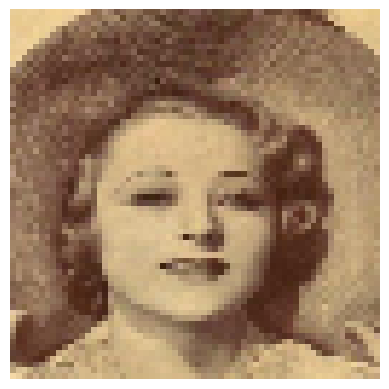

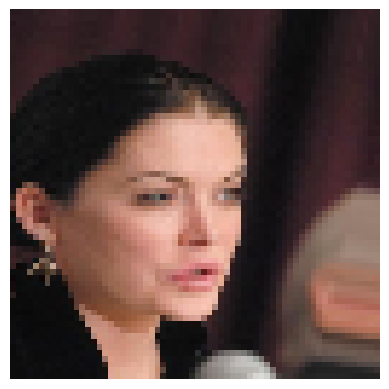

In [6]:
for idx, data_batch in enumerate(dataset):
    idx = 0
    for i in range(BATCH_SIZE):
        image = data_batch[i].numpy()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        idx += 1
        if(idx == 2): break
    break

In [7]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.tanh
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

## Improved WGAN

![](https://nthu-datalab.github.io/ml/labs/13-2_GAN/imgs/IWGAN%20algorithm.jpg)

In [8]:
WG_GP, WD_GP = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(W_LR, beta_1=0.5, beta_2=0.9)
optimizer_d = keras.optimizers.Adam(W_LR, beta_1=0.5, beta_2=0.9)
Lambda = 10

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG_GP(z, training = True)

        z1 = WD_GP(c1, training = True)
        z0 = WD_GP(c0, training = True)

        episolon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0.0, maxval=1.0)
        c2 = episolon * c1 + (1 - episolon) * c0

        with tf.GradientTape() as gt:
            gt.watch(c2)
            z2 = WD_GP(c2, training = True)

        gradient_c2 = gt.gradient(z2, c2)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient_c2), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

        ld = ld + Lambda * gradient_penalty

    gradient_g = tpg.gradient(lg, WG_GP.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG_GP.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG_GP(z, training = True) # fake image

        z1 = WD_GP(c1, training = True) # true pred
        z0 = WD_GP(c0, training = True) # fake pred

        episolon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0.0, maxval=1.0)
        c2 = episolon * c1 + (1 - episolon) * c0

        with tf.GradientTape() as gt:
            gt.watch(c2)
            z2 = WD_GP(c2, training = True)

        gradient_c2 = gt.gradient(z2, c2)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient_c2), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        
        ld = ld + Lambda * gradient_penalty

    gradient_d = tpd.gradient(ld, WD_GP.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD_GP.trainable_variables))
    
    return lg, ld

In [9]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

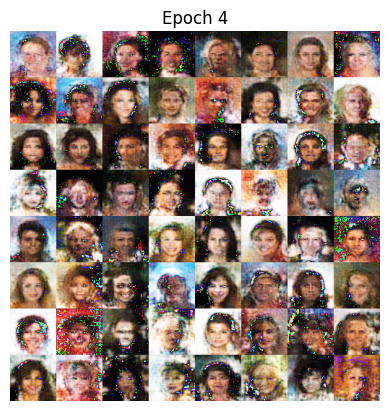

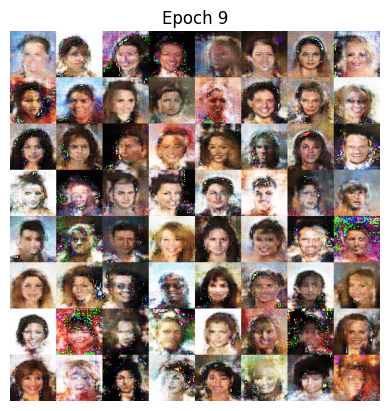

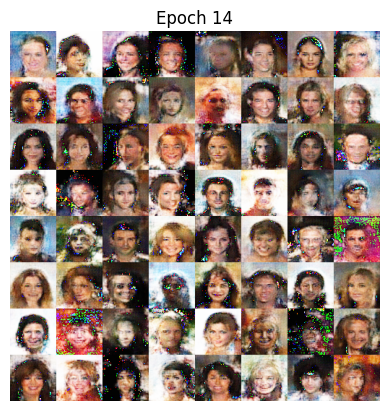

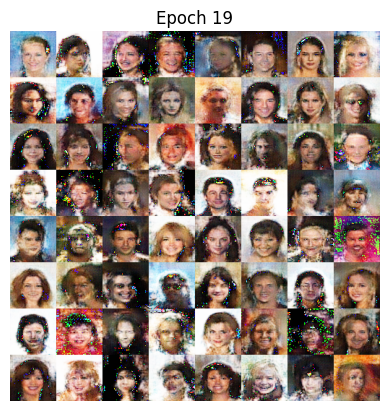

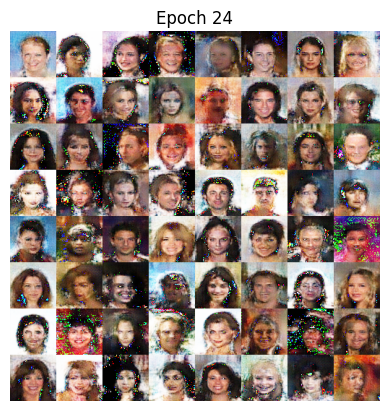

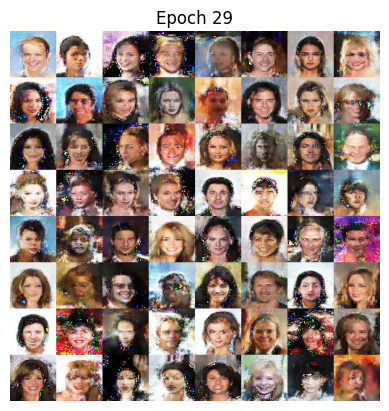

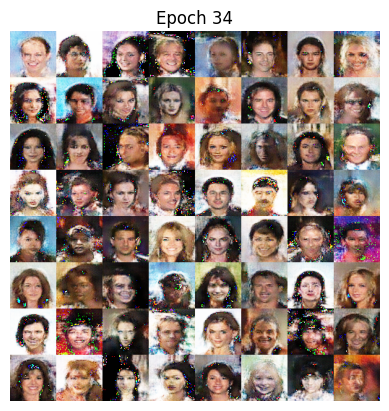

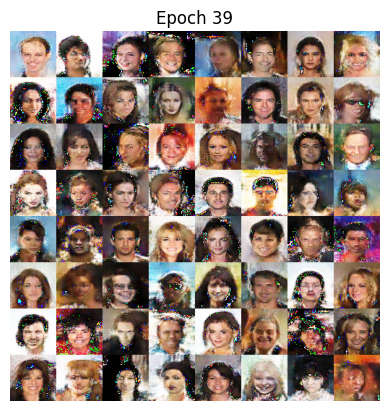

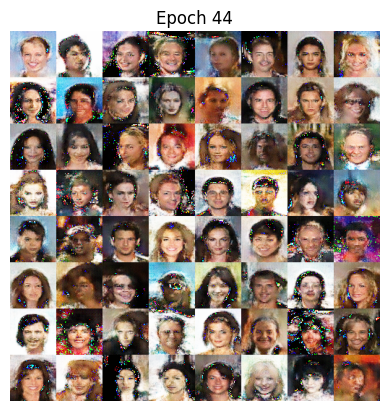

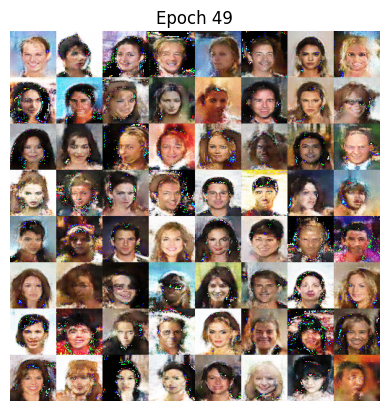

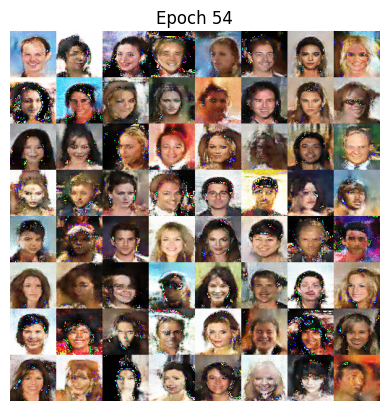

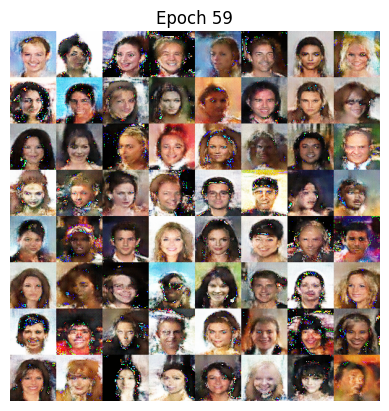

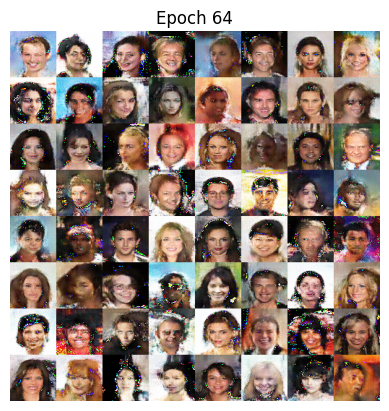

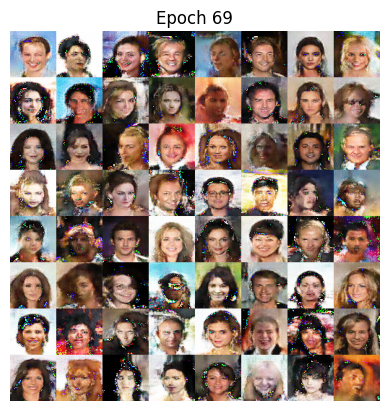

In [10]:
wlg_gp = [] #record loss of g for each epoch
wld_gp = [] #record loss of d for each epoch
wsp_gp = [] #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(image_names))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    cnt = 0
    for c1 in dataset:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
        cnt += 1

        if((cnt+1) % 200 == 0):
            wlg_gp.append(lgt * rsTrain)
            wld_gp.append(ldt * rsTrain)

    out = WG_GP(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/wgp_%04d.png" % ep
    )

    wsp_gp.append(img)
    if (ep+1) % 5 == 0:
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [11]:
utMakeGif(np.array(wsp_gp), "imgs/wgan_gp.gif", duration = 2)

MoviePy - Building file imgs/wgan_gp.gif with imageio.


### Loss Cruve

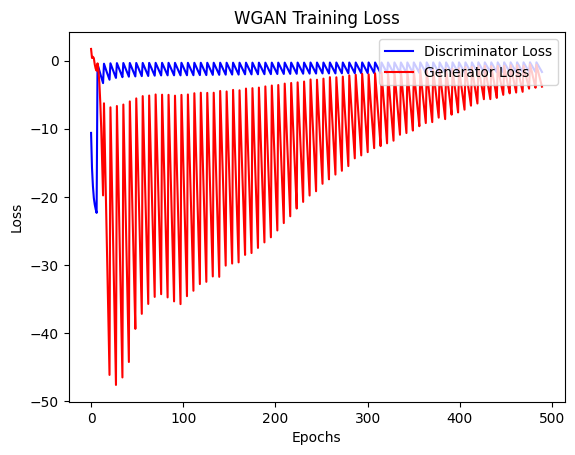

In [12]:
plt.plot(range(len(wld_gp)), wld_gp, color = "blue", label = "Discriminator Loss")
plt.plot(range(len(wlg_gp)), wlg_gp, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

### Show The Best Result

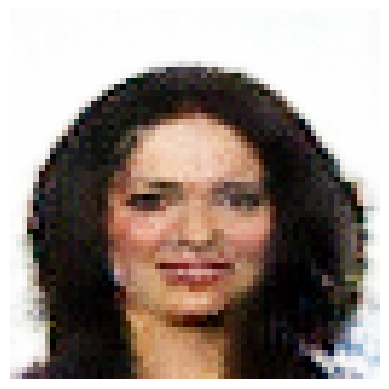

In [124]:
z = tf.random.normal((1, 128))
c0 = WG_GP(z, training = False)
image = np.clip(c0[0].numpy(), 0, 1)
plt.imshow(image)
plt.axis('off')
plt.show()

### Report

大致上就是按照作業的需求將圖片處理成指定格式，並且根據所需調整code的架構，再依據Improved WGAN的演算法將gradient penalty實作出來。

在實作完成後，我train了30個epoch發現人臉其實並沒有那麼清晰，所以我做了一個實驗，使用原本的WGAN進行訓練，發現原本的WGAN在訓練十幾個epochs過後，圖片的品質就會變得蠻好的了。隨後我以該結果做為比較，試著調整WGAN-GP的訓練，有嘗試過的方向例如以下：

- learning rate，batch size的調整
- Critic（Discriminator與Generator的交互次數）的調整
- image preprocess將值調整成-1~1 or 0~1
- Generator最後一層的輸出改成tanh，Discriminator移除BatchNormalization